In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pywt 
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import *
from keras.models import Sequential
from keras.callbacks import *
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix
import gc
import os
lsdir = "../input"
print(os.listdir(lsdir))

from time import time
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler,LabelEncoder
from matplotlib import rcParams
%matplotlib inline
le = preprocessing.LabelEncoder()
from numba import jit
import itertools
from seaborn import countplot,lineplot, barplot
from sklearn.feature_selection import SelectKBest,chi2
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut,RandomizedSearchCV,GroupKFold,KFold

Using TensorFlow backend.


['X_train.csv', 'sample_submission.csv', 'X_test.csv', 'y_train.csv']


In [2]:
data = pd.read_csv(lsdir+'/X_train.csv')
target = pd.read_csv(lsdir+'/y_train.csv')
test = pd.read_csv(lsdir+'/X_test.csv')
submission = pd.read_csv(lsdir+'/sample_submission.csv')

In [3]:
# this part credit to https://www.kaggle.com/jesucristo/1-smart-robots-complete-notebook-0-73

def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)
    return X, Y, Z


def fe_step0 (actual):
    actual['norm_quat'] = (actual['orientation_X']**2 + actual['orientation_Y']**2 + actual['orientation_Z']**2 + actual['orientation_W']**2)
    actual['mod_quat'] = (actual['norm_quat'])**0.5
    actual['norm_X'] = actual['orientation_X'] / actual['mod_quat']
    actual['norm_Y'] = actual['orientation_Y'] / actual['mod_quat']
    actual['norm_Z'] = actual['orientation_Z'] / actual['mod_quat']
    actual['norm_W'] = actual['orientation_W'] / actual['mod_quat']
    return actual

def fe_step1 (actual):
    """Quaternions to Euler Angles"""
    
    x, y, z, w = actual['norm_X'].tolist(), actual['norm_Y'].tolist(), actual['norm_Z'].tolist(), actual['norm_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    return actual

data = fe_step0(data)
test = fe_step0(test)
data = fe_step1(data)
test = fe_step1(test)
print (data.shape)
data.head()

(487680, 22)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698


In [4]:
def feat_eng(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2)**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2)**0.5
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
   
    groupeddata = data.groupby('series_id').agg(lambda x: x.tolist()).reset_index()
    groupeddata.drop(['series_id','row_id','measurement_number'],axis=1,inplace=True)
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    def der_and_intgeral(row,col,s):
        x=row[col]
        l=len(x)
        intgeral = [np.mean(x[max(0,i-s):min(l,i+s)]) for i in range(l)]
        detail = np.array(x)- np.array(intgeral)
        detail = detail[s:l-s]
        return detail
    
#     for col in groupeddata.columns:
#         groupeddata[col+'_detl'] = groupeddata.apply(der_and_intgeral,col=col,s=5,axis=1)
        #groupeddata[col+'_detl'] = groupeddata.apply(der_and_intgeral,col=col+'_detl',s=5,axis=1) 
    
#     perc = [1,10,25,75,90,99]
    for col in groupeddata.columns:
#         percentil = np.array([np.percentile(x, perc) for x in groupeddata[col]])
#         for p,pc in enumerate(perc):
#             df[col+'_'+str(pc)+'%'] = percentil[:,p]
        
        df[col + '_mean'] = [np.mean(x) for x in groupeddata[col]]
        df[col + '_median'] = [np.median(x) for x in groupeddata[col]]
        df[col + '_max'] = [np.max(x) for x in groupeddata[col]]
        df[col + '_min'] = [np.min(x) for x in groupeddata[col]]
        df[col + '_std'] = [np.std(x) for x in groupeddata[col]]
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = [np.mean(np.abs(np.diff(x))) for x in groupeddata[col]]
        df[col + '_mean_change_of_abs_change'] = [mean_change_of_abs_change(x) for x in groupeddata[col]]
        df[col + '_abs_max'] = [np.max(np.abs(x)) for x in groupeddata[col]]
        df[col + '_abs_min'] = [np.min(np.abs(x)) for x in groupeddata[col]]
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2

    
    return df

In [5]:
%%time
data = feat_eng(data)
test = feat_eng(test)
print ("New features: ",data.shape)

New features:  (3810, 276)
CPU times: user 54.9 s, sys: 1.44 s, total: 56.4 s
Wall time: 55.7 s


In [6]:
data.fillna(0,inplace=True)
test.fillna(0,inplace=True)
data.replace(-np.inf,0,inplace=True)
data.replace(np.inf,0,inplace=True)
test.replace(-np.inf,0,inplace=True)
test.replace(np.inf,0,inplace=True)

In [7]:
target['surface'].value_counts()

concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64

In [8]:
rareindex = target.loc[target['surface']=='hard_tiles'].index

In [9]:
onehot = pd.get_dummies(target['surface'])
y_train_labels = onehot.columns
target['surface'] = np.argmax(onehot.values,axis=1)

In [10]:
from random import shuffle
# folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=2019)
# for times, (trn_idx, val_idx) in enumerate(folds.split(data.values,target['surface'].values)):
#     trn_idx = list(trn_idx)+list(rareindex)
#     shuffle(trn_idx)
#     print(trn_idx, val_idx)
#     break

In [11]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
predicted = np.zeros((test.shape[0],9))
measured= np.zeros((data.shape[0]))
score = 0

Fold: 0 score: 0.9168831168831169


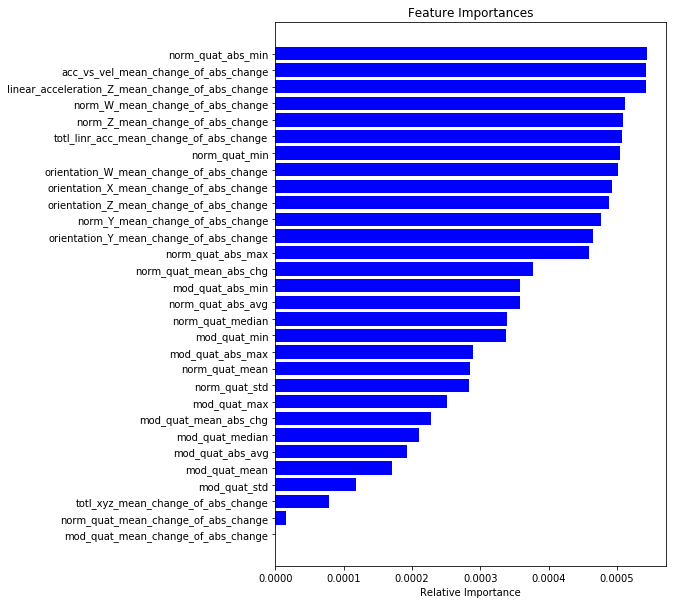

Fold: 1 score: 0.90625


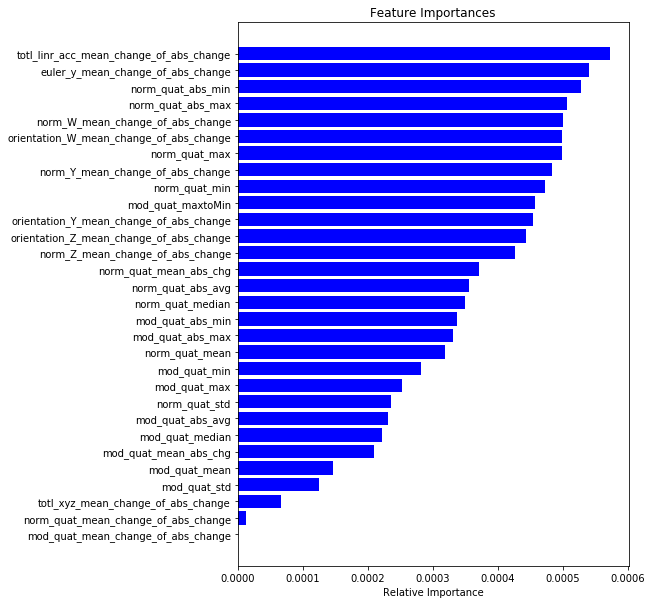

Fold: 2 score: 0.9373368146214099


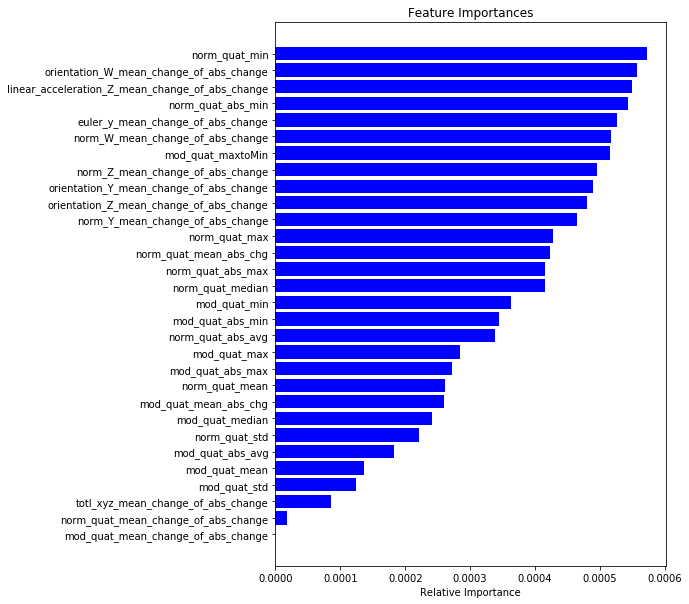

Fold: 3 score: 0.918848167539267


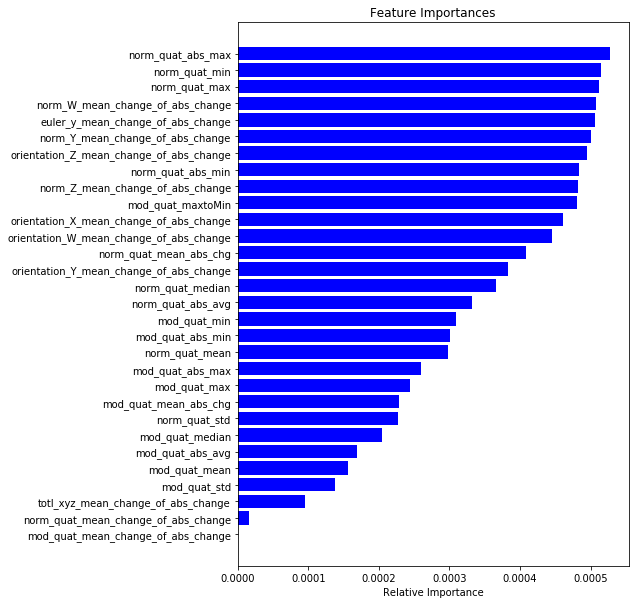

Fold: 4 score: 0.8871391076115486
Fold: 5 score: 0.9501312335958005


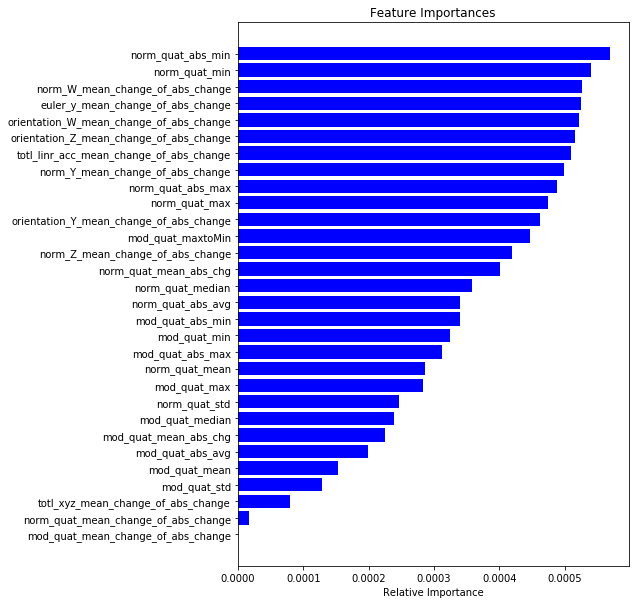

Fold: 6 score: 0.884514435695538
Fold: 7 score: 0.9023746701846965


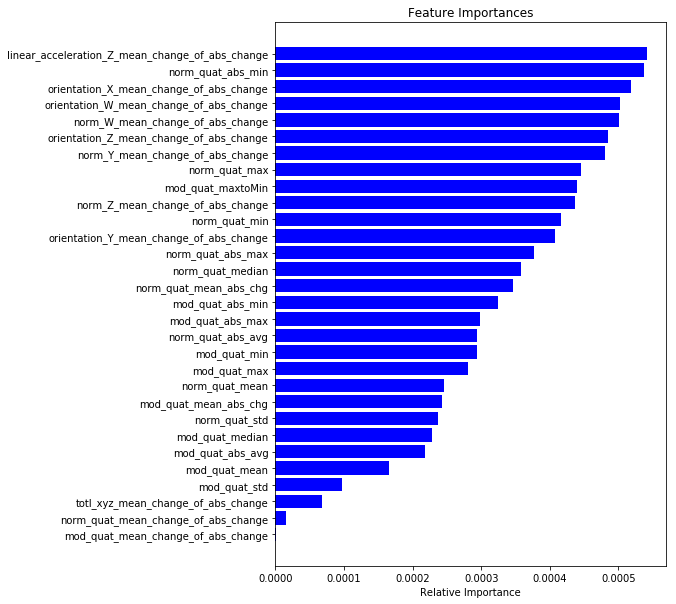

Fold: 8 score: 0.8915343915343915
Fold: 9 score: 0.9574468085106383


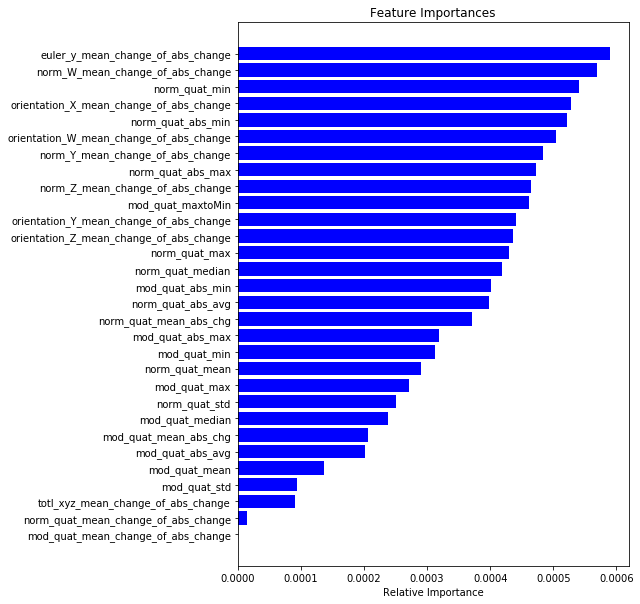

In [12]:
for times, (trn_idx, val_idx) in enumerate(folds.split(data.values,target['surface'].values)):
#     trn_idx = list(trn_idx)+list(rareindex)
#     shuffle(trn_idx)
    model = RandomForestClassifier(n_estimators=500, n_jobs = -1,class_weight = 'balanced')
    #model = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, n_jobs=-1)
    model.fit(data.iloc[trn_idx],target['surface'][trn_idx])
    measured[val_idx] = model.predict(data.iloc[val_idx])
    predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(data.iloc[val_idx],target['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(data.iloc[val_idx],target['surface'][val_idx])))

    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = data.columns
    
    if model.score(data.iloc[val_idx],target['surface'][val_idx]) > 0.90000:
        hm = 30
        plt.figure(figsize=(7, 10))
        plt.title('Feature Importances')
        plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
        plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

    gc.collect()

In [13]:
print('Avg Accuracy RF', score / folds.n_splits)
matrix = confusion_matrix(measured,target['surface'])
print(matrix)

Avg Accuracy RF 0.9152458746176407
[[161   5   0   0   1   5   0   1   0]
 [ 13 705  12   0   8  13   4  14   9]
 [  0   3 316   0   4   4   1   1   4]
 [  0   0   0  17   0   0   1   0   1]
 [  0  13   0   0 287   5   0   2   1]
 [  2  14   8   0   1 687   3   7  18]
 [  1  10   1   2   1   3 285   2   0]
 [  1   3   3   0   0   3   0 474  19]
 [ 11  26  23   2   6  12   3  13 555]]


In [14]:
preds_test = np.argmax(predicted,axis=1)
preds_test = [y_train_labels[i] for i in preds_test]
print(preds_test[:10])

['hard_tiles_large_space', 'concrete', 'tiled', 'carpet', 'soft_tiles', 'concrete', 'soft_pvc', 'concrete', 'wood', 'wood']


In [15]:
submission['surface'] = preds_test
submission.to_csv('submission.csv', index=False)
submission.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles


In [16]:
submission['surface'].value_counts()

concrete                  923
wood                      776
soft_pvc                  647
soft_tiles                463
tiled                     319
hard_tiles_large_space    290
fine_concrete             267
carpet                    121
hard_tiles                 10
Name: surface, dtype: int64

In [17]:
target['surface'].value_counts()

1    779
5    732
8    607
7    514
2    363
4    308
6    297
0    189
3     21
Name: surface, dtype: int64